# Plotting with xarray, matplotlib and cartopy

First, some homework to do here:

In [25]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
# set default plot size larger for convenience
matplotlib.rcParams['figure.figsize'] = (12, 8)

We use REMO topography as an example dataset.

In [12]:
topo = "/pool/data/CORDEX/data/cordex/output/EUR-11/GERICS/ECMWF-ERAINT/evaluation/r0i0p0/GERICS-REMO2015/v1/fx/orog/v20180813/orog_EUR-11_ECMWF-ERAINT_evaluation_r0i0p0_GERICS-REMO2015_v1_fx.nc"
remo = xr.open_dataset(topo)
remo

<xarray.Dataset>
Dimensions:                     (rlat: 412, rlon: 424, vertices: 4)
Coordinates:
  * rlat                        (rlat) float64 -23.38 -23.27 ... 21.72 21.84
  * rlon                        (rlon) float64 -28.38 -28.27 ... 18.04 18.16
    lat                         (rlat, rlon) float32 ...
    lon                         (rlat, rlon) float32 ...
Dimensions without coordinates: vertices
Data variables:
    rotated_latitude_longitude  int32 ...
    lat_vertices                (rlat, rlon, vertices) float32 ...
    lon_vertices                (rlat, rlon, vertices) float32 ...
    orog                        (rlat, rlon) float32 ...
Attributes: (12/29)
    institution:                    Helmholtz-Zentrum Geesthacht, Climate Ser...
    institute_id:                   GERICS
    experiment_id:                  evaluation
    source:                         GERICS-REMO2015
    model_id:                       GERICS-REMO2015
    contact:                        gerics-cordex@hzg.de
    ...                             ...
    project_id:                     CORDEX
    table_id:                       Table fx (Sept 2013) 54b02165bac4f892dfda...
    title:                          GERICS-REMO2015 model output prepared for...
    modeling_realm:                 atmos
    realization:                    0
    cmor_version:                   2.9.1

In [13]:
pole = ( remo.rotated_latitude_longitude.grid_north_pole_longitude,  remo.rotated_latitude_longitude.grid_north_pole_latitude)
pole

(-162.0, 39.25)

Working wiht matplotlib API can become confusing and needs some experience. However, there are some nice high-level APIs that utilize matploblib and give easy plotting capabilities, e.g.,
* xarray
* seaborn
* cartopy
* holoviews
* ...

## First look

xarray makes it easy to quickly explore and look at your data because it has an easy interface to matplotlib, simply call plot!

Text(0.5, 1.0, 'REMO orography in native coordinates')

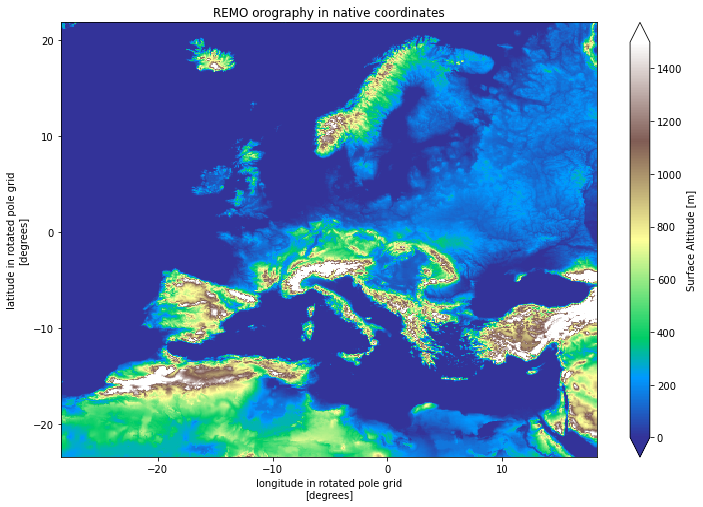

In [14]:
remo.orog.plot(cmap='terrain', vmin=0, vmax=1500)
plt.title('REMO orography in native coordinates')

xarray by default plots the data in its native coordinate system, here that's (`rlon`, `rlat`). It's also easy to plot it in the global (`lon`, `lat`) coordinates:

Text(0.5, 1.0, 'REMO orography in global coordinates')

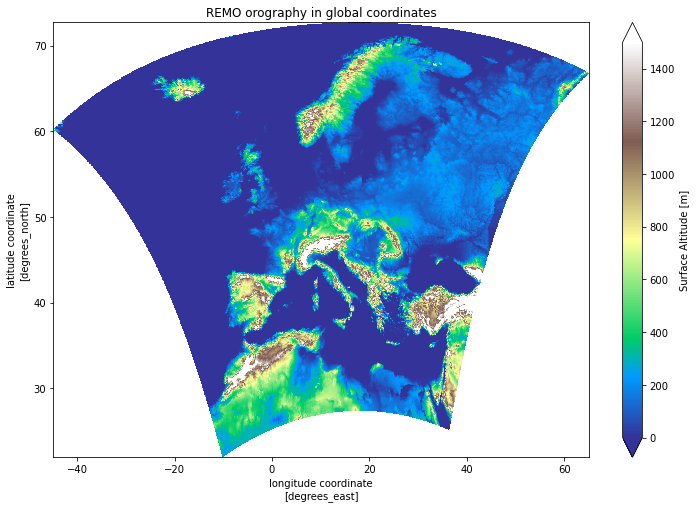

In [15]:
remo.orog.plot(cmap='terrain', vmin=0, vmax=1500, x='lon', y='lat')
plt.title('REMO orography in global coordinates')

## Using transformations and projections

Knowing some basics about matplotlib will give you more power over it's plotting capabilities, e.g., using the axis for adapting your plot and cartopy for [transformations and projections](https://scitools.org.uk/cartopy/docs/latest/tutorials/understanding_transform.html).

First, let's defina a convenient plotting function that takes an xarray dataset as input. We set the default transformation and projection of the plot to [plane map](https://en.wikipedia.org/wiki/Equirectangular_projection).

In [58]:
def plot(da, transform=ccrs.PlateCarree(), projection=ccrs.PlateCarree(), vmin=None, vmax=None, borders=True, 
         xlocs=range(-180,180,10), ylocs=range(-90,90,5), extent=None, figsize=(15,10), title=''):
    """plot a domain using the right projections and transformations with cartopy"""
    %matplotlib inline
    import cartopy.crs as ccrs
    import cartopy.feature as cf
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    ax = plt.axes(projection=projection)
    if extent:
        #ax.set_extent([ds_sub.rlon.min(), ds_sub.rlon.max(), ds_sub.rlat.min(), ds_sub.rlat.max()], crs=transform)
        ax.set_extent(extent, crs=projection)
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray',
                      xlocs=xlocs, ylocs=ylocs)
    da.plot(ax=ax, cmap='terrain', transform=transform, vmin=vmin, vmax=vmax)
    ax.coastlines(resolution='50m', color='black', linewidth=1)
    if borders: ax.add_feature(cf.BORDERS)
    ax.set_title('')

### Plot rotated pole mappings

Let's plot with default transformations and projections and see what happens.

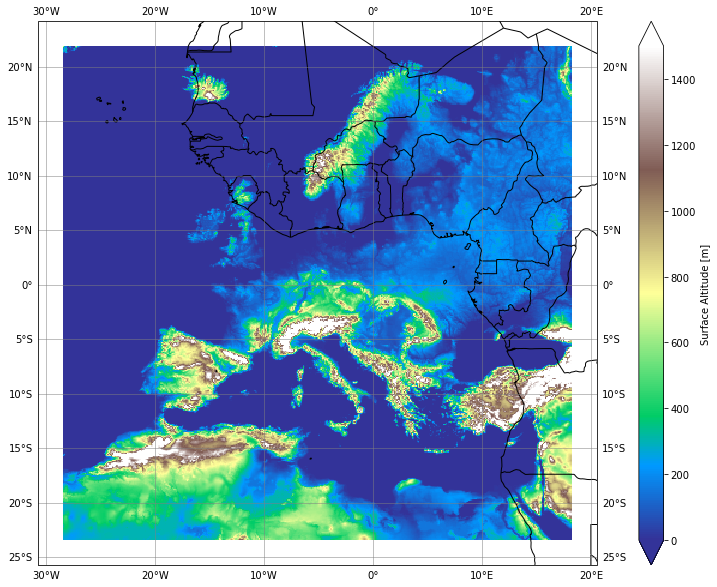

In [33]:
plot(remo.orog, vmin=0, vmax=1500)

By default, the plot is in its native coordinate systen, but cartopy doesn't know about the rotated coordinates yet. That's why the coastlines are plotted in the unrotated geographic coordinates. With the transformation, we can simply tell cartopy how to project the data on the default Plate Carree map.

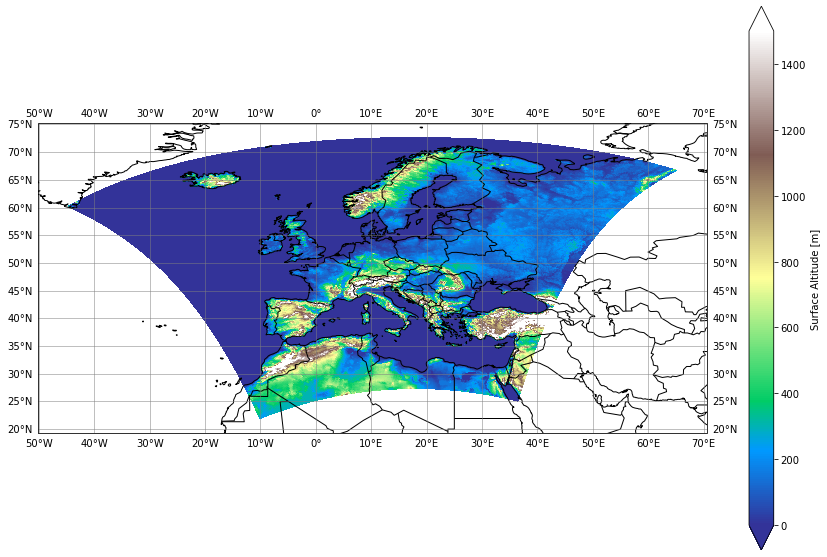

In [35]:
plot(remo.orog, transform = ccrs.RotatedPole(*pole), vmin=0, vmax=1500)

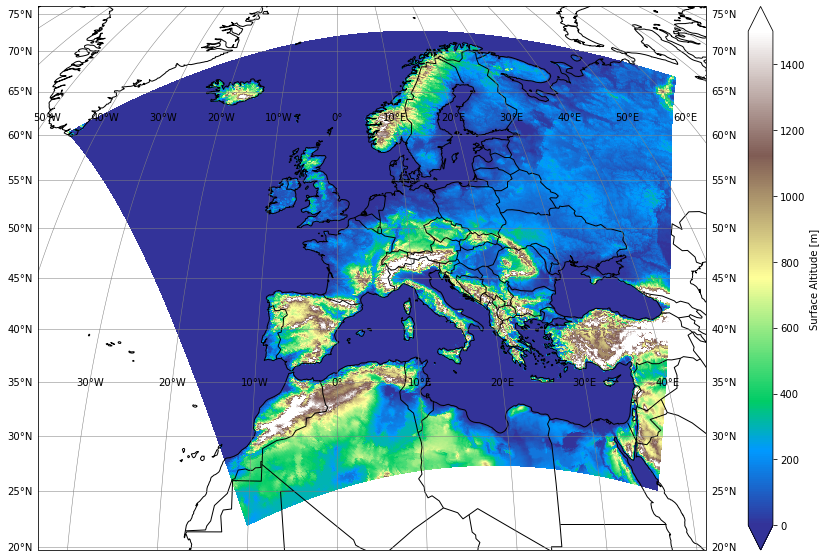

In [62]:
plot(remo.orog, transform = ccrs.RotatedPole(*pole), projection=ccrs.Mollweide(), vmin=0, vmax=1500)

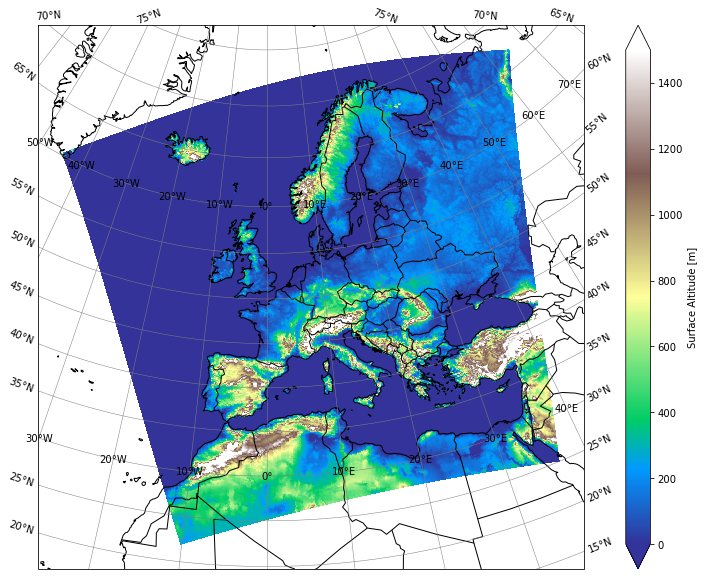

In [65]:
plot(remo.orog, transform = ccrs.RotatedPole(*pole), projection=ccrs.LambertConformal(central_longitude=0.0, central_latitude=0.0,), vmin=0, vmax=1500)

In [ ]:
plot(remo.orog, transform = ccrs.RotatedPole(*pole), projection=ccrs.Mollweide(), vmin=0, vmax=1500)

Now, the data is correctly projected onto the map. However, for Cordex domains it seems more convenient to plot the data in the rotated projection. We can do this as well by changing the projection also to rotated pole.

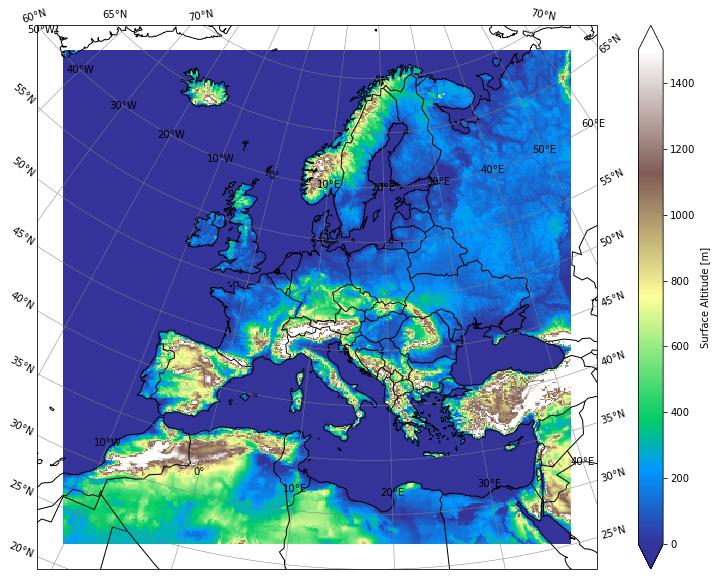

In [29]:
plot(remo.orog, transform = ccrs.RotatedPole(*pole), projection=ccrs.RotatedPole(*pole), vmin=0, vmax=1500)

### Plot global gcm data

Let's grep some global gcm data, e.g., MPI-ESM-HR from CMIP6.

In [10]:
mpi_esm = xr.open_dataset("/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r10i1p1f1/fx/orog/gn/v20190710/orog_fx_MPI-ESM1-2-HR_historical_r10i1p1f1_gn.nc")

Let's do a plot on the default plane map. That should be best for global data.

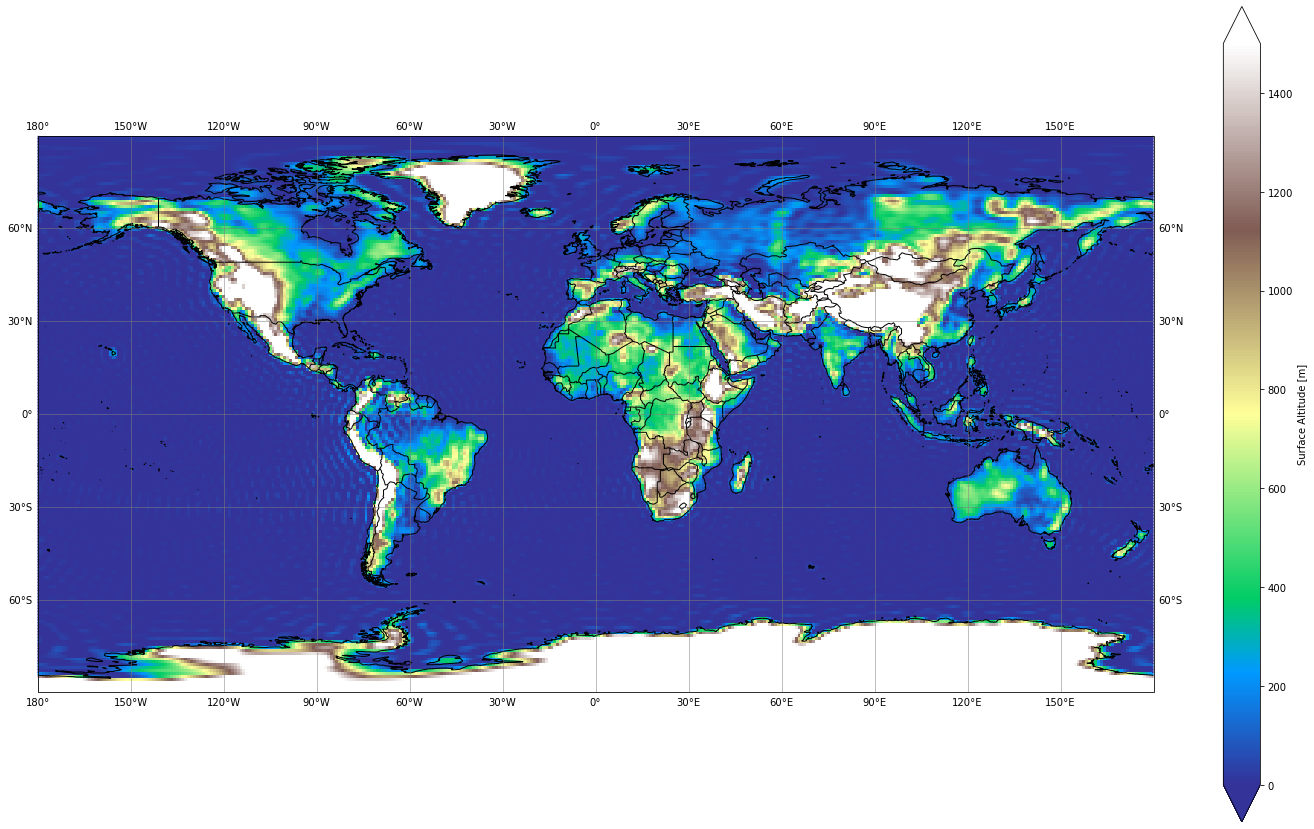

In [52]:
plot(mpi_esm.orog, vmin=0, vmax=1500, xlocs=range(-180,180,30), ylocs=range(-90,90,30), figsize=(25, 15))

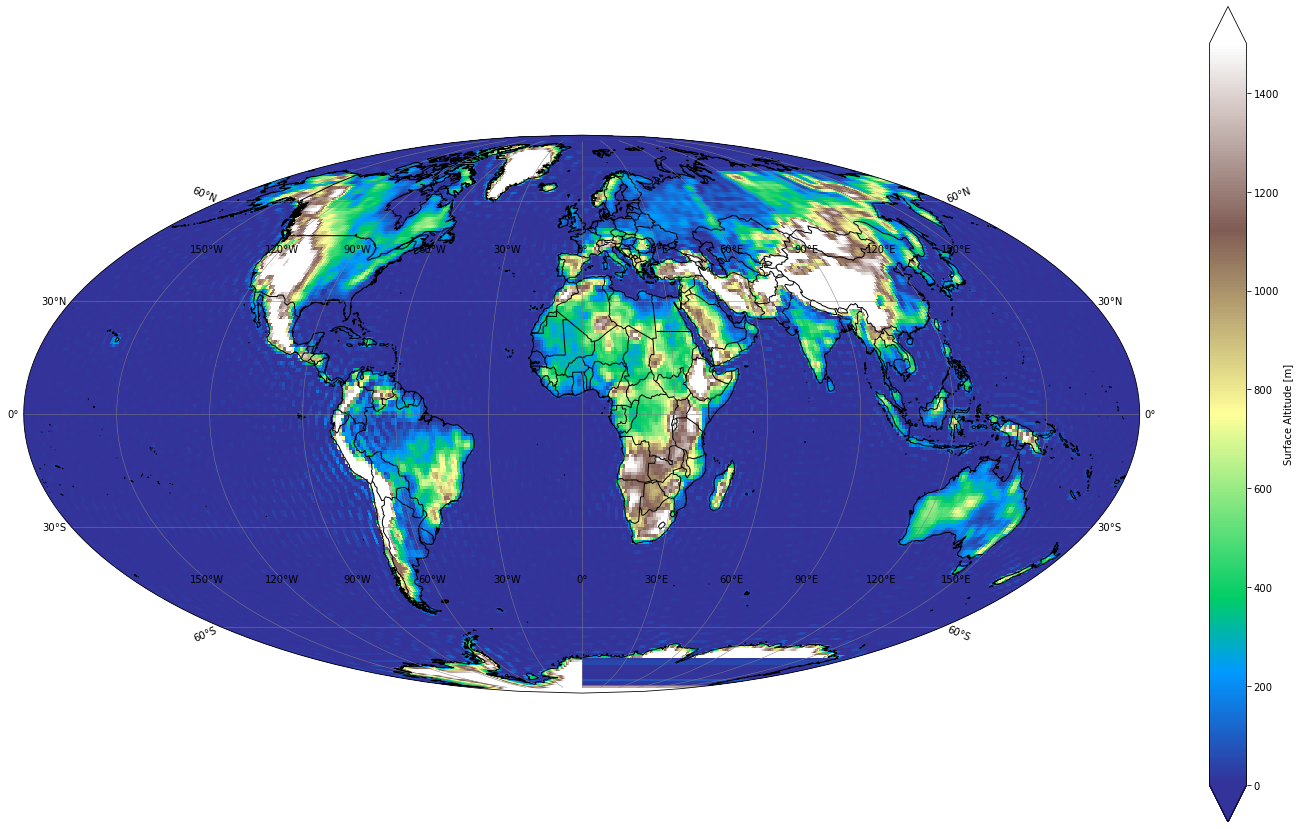

In [61]:
plot(mpi_esm.orog, projection=ccrs.Mollweide(), vmin=0, vmax=1500, xlocs=range(-180,180,30), ylocs=range(-90,90,30), figsize=(25, 15))

That looks good! But we can even plot global data into our Cordex rotated projection for better comparison.

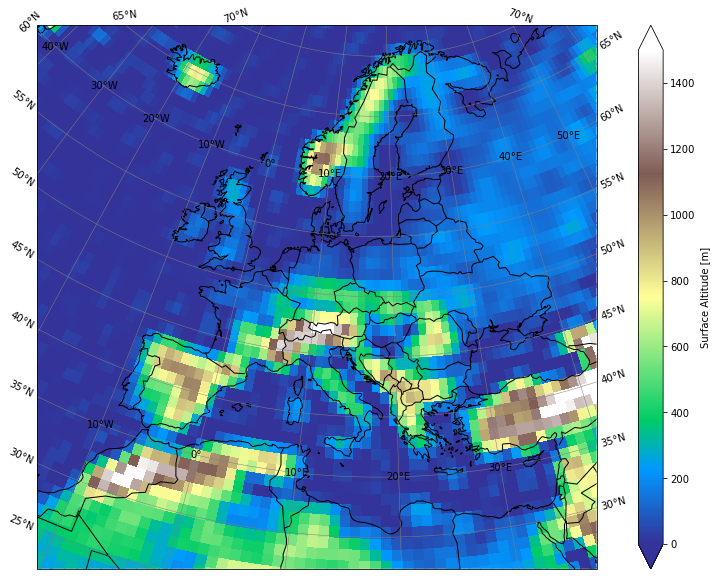

In [60]:
plot(mpi_esm.orog, projection=ccrs.RotatedPole(*pole), extent=[remo.rlon.min(), remo.rlon.max(), remo.rlat.min(), remo.rlat.max()], vmin=0, vmax=1500)

You see that we plotted everythink with the same function which required just very little boilerplate code!